In [185]:
import psycopg2
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
conn = psycopg2.connect(host="postgres", port = 5432, database="development", user="user", password="password")

In [3]:
employees = pd.read_sql_query("select * from employees", conn)

In [4]:
employees.head()

,id,code,first_name,last_name,middle_name,hire_date,user_id,color,compensation_type,last_modified
0,64,1234,Kurt,Knolle,,2014-05-09,13,#6a3d9a,None,2020-07-10 20:46:31.911182
1,65,0184,Matt,Cherkis,,2015-11-23,14,#1f78b4,None,2020-07-10 20:46:31.917934
2,66,1413,Matt,Constantin,J,2019-01-14,15,#33a02c,None,2020-07-10 20:46:31.925686
3,67,1998,Michael,Dollas-Halbach,F,2018-04-09,16,#e31a1c,None,2020-07-10 20:46:31.932059
4,69,2054,Noah,Haefner,A,2016-04-26,17,#6a3d9a,None,2020-07-10 20:46:31.938320


In [5]:
employees_map = dict(zip(employees['id'], employees['first_name'].str.lower().str[0] + employees['last_name'].str.lower()))

In [6]:
dataset = pd.read_sql_query('''
    select
        employee_id,
        extract(epoch from cast(date_start as time)) as date_start,
        extract(epoch from duration) as duration
    from timeclock_shifts_view
    where date_stop is not null
    order by date_stop desc, date_start desc
''', conn)

In [7]:
dataset['employee_id'] = dataset['employee_id'].map(employees_map)

In [8]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,date_start,duration,ajolls,aplewa,arichardson,bbauer,bhall,bplewa,caures,clowe,...,mdollas-halbach,nhaefner,plewandowski,proberts,rhurd,rmawhinney,rsteiner,szagrobelny,tharling,thorn
3980,37620.0,30754.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3981,42900.0,18360.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3982,32940.0,31680.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3983,32100.0,30629.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3984,41520.0,19757.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [9]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print(train_dataset.shape, test_dataset.shape)

(3188, 31) (797, 31)


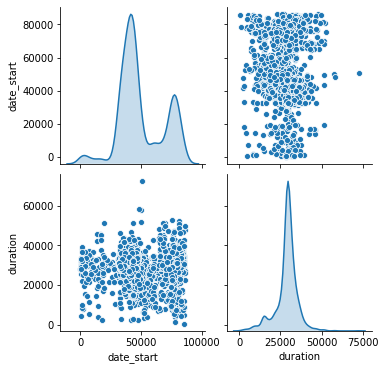

In [10]:
sns.pairplot(train_dataset[["date_start", "duration"]], diag_kind="kde")

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("duration")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
date_start,3188.0,49789.930364,18559.844267,104.0,38296.0,43462.0,66378.5,86322.0
ajolls,3188.0,0.025721,0.158328,0.0,0.0,0.0,0.0,1.0
aplewa,3188.0,0.059285,0.236194,0.0,0.0,0.0,0.0,1.0
arichardson,3188.0,0.017566,0.131388,0.0,0.0,0.0,0.0,1.0
bbauer,3188.0,0.056775,0.231449,0.0,0.0,0.0,0.0,1.0
bhall,3188.0,0.007842,0.088220,0.0,0.0,0.0,0.0,1.0
bplewa,3188.0,0.054266,0.226577,0.0,0.0,0.0,0.0,1.0
caures,3188.0,0.010351,0.101229,0.0,0.0,0.0,0.0,1.0
clowe,3188.0,0.038896,0.193377,0.0,0.0,0.0,0.0,1.0
dgasiewicz,3188.0,0.056462,0.230847,0.0,0.0,0.0,0.0,1.0


In [12]:
train_labels = train_dataset.pop('duration') # used to identify predicted value
test_labels = test_dataset.pop('duration')

In [13]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [14]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1984      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,209
Trainable params: 6,209
Non-trainable params: 0
_________________________________________________________________


In [15]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:876425728.0000,  mae:28870.1523,  mse:876425728.0000,  val_loss:859627712.0000,  val_mae:28591.9961,  val_mse:859627712.0000,  
....................................................................................................
Epoch: 100, loss:27878870.0000,  mae:3453.0518,  mse:27878870.0000,  val_loss:29468306.0000,  val_mae:3675.8569,  val_mse:29468306.0000,  
....................................................................................................
Epoch: 200, loss:27296750.0000,  mae:3418.5725,  mse:27296750.0000,  val_loss:29446048.0000,  val_mae:3650.6086,  val_mse:29446048.0000,  
....................................................................................................
Epoch: 300, loss:26863474.0000,  mae:3384.4592,  mse:26863474.0000,  val_loss:29528282.0000,  val_mae:3640.4460,  val_mse:29528282.0000,  
....................................................................................................
Epoch: 400, loss:26524416.0000,  ma

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,25180464.0,3238.919434,25180464.0,29367178.0,3556.310059,29367178.0,995
996,25194702.0,3236.637207,25194702.0,29246436.0,3556.590820,29246436.0,996
997,25211474.0,3235.545410,25211474.0,29246842.0,3557.961914,29246842.0,997
998,25208366.0,3234.176270,25208366.0,29208742.0,3555.095215,29208742.0,998
999,25169484.0,3238.112305,25169484.0,29157110.0,3561.758545,29157110.0,999


Text(0, 0.5, 'MAE [MPG]')

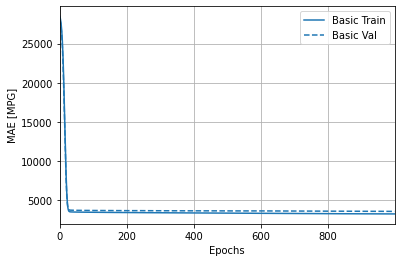

In [17]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
#plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

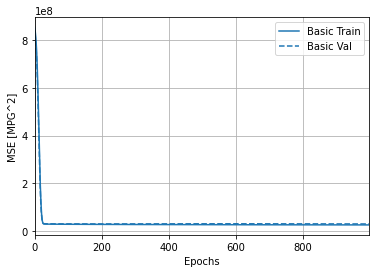

In [18]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylabel('MSE [MPG^2]')

In [19]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} Seconds".format(mae))

25/25 - 0s - loss: 20826946.0000 - mae: 3125.7864 - mse: 20826946.0000
Testing set Mean Abs Error: 3125.79 Seconds


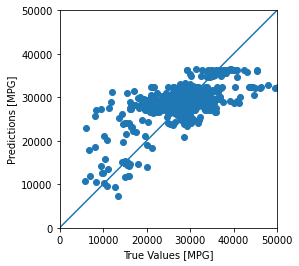

In [21]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

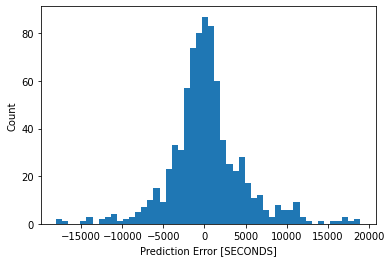

In [110]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [SECONDS]")
_ = plt.ylabel("Count")

In [180]:
test_date_start = datetime(2020, 2, 5, 12)
def get_seconds(dt):
    t = dt.time()
    s = (t.hour * 60 + t.minute) * 60 + t.second
    return s

#employee_id = 57

def make_prediction(dt, employee_id):
    test = pd.DataFrame(columns=normed_test_data.columns)
    val = pd.DataFrame([{'employee_id': employee_id, 'date_start': get_seconds(dt)}])
    val['employee_id'] = val['employee_id'].map(employees_map)
    val = pd.get_dummies(val, prefix='', prefix_sep='')

    for col in normed_test_data.columns:
        if col not in val:
            val[col] = 0

    val = val[[c for c in normed_test_data.columns]]
    val = norm(val)

    return model.predict(val).flatten()

prediction = make_prediction(test_date_start, employee_id)
'when starting at {}: {:.3} hours'.format(test_date_start, prediction[0] / 3600)

'when starting at 2020-02-05 12:00:00: 7.94 hours'

[7.0890718 6.7678146 6.5263715 6.6160145 6.778816  6.9635916 7.124605
 7.2862034 7.447801  7.6094    7.7709985 7.8696337 7.941344  7.983847
 8.026349  8.0688505 8.111354  8.153855  8.196358  8.238859  8.281363
 8.323865  8.232917  7.904794 ]
[[[datetime.datetime(2020, 1, 1, 0, 0) 7.089071750640869]
  [datetime.datetime(2020, 1, 1, 1, 0) 6.767814636230469]
  [datetime.datetime(2020, 1, 1, 2, 0) 6.526371479034424]
  [datetime.datetime(2020, 1, 1, 3, 0) 6.61601448059082]
  [datetime.datetime(2020, 1, 1, 4, 0) 6.778816223144531]
  [datetime.datetime(2020, 1, 1, 5, 0) 6.963591575622559]
  [datetime.datetime(2020, 1, 1, 6, 0) 7.124605178833008]
  [datetime.datetime(2020, 1, 1, 7, 0) 7.286203384399414]
  [datetime.datetime(2020, 1, 1, 8, 0) 7.447801113128662]
  [datetime.datetime(2020, 1, 1, 9, 0) 7.609399795532227]
  [datetime.datetime(2020, 1, 1, 10, 0) 7.770998477935791]
  [datetime.datetime(2020, 1, 1, 11, 0) 7.869633674621582]
  [datetime.datetime(2020, 1, 1, 12, 0) 7.941343784332275]
  

Text(0, 0.5, 'Predictions [MPG]')

<Figure size 432x288 with 0 Axes>

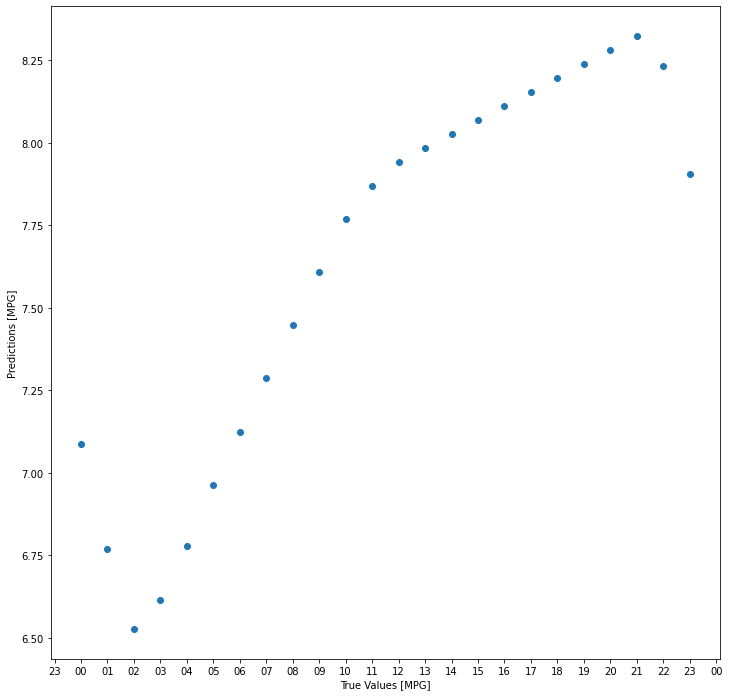

In [195]:
plt.clf()
plt.figure(figsize=(12,12))
base = datetime(2020, 1, 1)
xx = np.array([base + i * timedelta(hours=1) for i in range(24)])
f = lambda dt: make_prediction(dt, 57)
yy = np.vectorize(f)(xx) / 3600
print(yy)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.scatter(xx, yy)
print(np.dstack((xx, yy)))
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
#lims = [0, 50000]
#plt.xlim(lims)
#plt.ylim(lims)
#plt.plot(lims, lims)